# Tráfego automóvel

Vamos estudar uma lei de conservação que modela o tráfego automóvel numa auto-estrada sem entradas nem saídas no troço sob estudo.

No estudo da advecção vimos que podíamos escrever essa equação na forma de uma equação de conservação:

$$u_t + (vu)_x = 0.$$

Neste caso vamos usar $u$ para descrever a densidade de automóveis na estrada, a viajarem à velocidade $v$. Não representamos assim cada carro individualmente, mas sim a média de carros por unidade de comprimento de estrada. Deste modo $u=0$ quer dizer que localmente não há carros, e $u=1$ (vamos escolher unidades normalizadas) quer dizer que os carros estão "encostados".

As nossas unidades são também escolhidas de modo a que $v_\text{max}=1$, e nenhum condutor ultrapassa este limite (pois, é um problema teórico!;) ). No caso de supormos que todos os carros viajam sempre à mesma velocidade constante, re-obtemos a equação de advecção. Mas como é evidente, não é uma situação realista: quando há menos tráfego os condutores viajam mais depressa, quando o tráfego se adensa, abrandam. O modo mais simples de incluir esta fenomenologia na equação é considerar que a velocidade é uma função decrescente da densidade. Por exemplo:


$$v(u) = 1 - u.$$

Deste modo $v$ diminui até zero à medida que a densidade $u$ se aproxima do valor máximo de 1, enquanto que $v$ tende para a velocidade máxima de 1 à medida que a densidade de tráfego se aproxima de zero. Assim, nestas unidades normalizadas, tanto a densidade $u$ como a velocidade $v$ variam no intervalo $[0,1]$.

<img src="../imagens/velocidade-LWR.png" alt="velocidade" width="220"/>


Combinando as duas equações acima, escrevemos a lei de conservação como:

$$u_t + (u (1-u))_x = 0.$$

A função $u(1-u)$ é o fluxo de carros, ou taxa de passagem num ponto por unidade de tempo. O fluxo é zero quando há engarrafamento (extremo!). O fluxo máximo ocorre quando a estrada está ocupada a $50\%$ da capacidade, como podemos ver na figura:

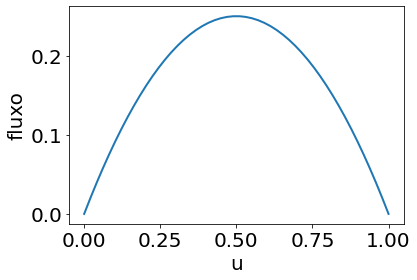

In [13]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

u = np.linspace(0,1)
f = u*(1.-u)
plt.plot(u,f,linewidth=2)
plt.xlabel('u'); plt.ylabel('fluxo'); 

Esta equação é diferente, de um modo fundamental, da equação de advecção, pois o fluxo é **não-linear**. Este facto tem consequências dramáticas quer para a forma das soluções, quer para os métodos numéricos necessários para integrar a equação. Mas podemos dar à equação uma aparência de equação de advecção usando a derivação em cadeia:

$$f(u)_x = f'(u) u_x = (1-2u)u_x.$$

Então temos:

$$u_t + (1-2u)u_x = 0.$$

Esta equação tem a forma da equação de advecção, mas em vez de ter velocidade constante, esta é $1-2u$, ié, depende da densidade de automóveis. À quantidade $f'(u)=1-2u$ chamamos *velocidade característica*. Esta velocidade *não* é a velocidade com que os carros se deslocam (note que até pode ser negativa!). É antes a velocidade a que (algum tipo de) informação é transmitida ao longo da estrada.

## Ondas de choque (engarrafamentos)

Vamos usar o método de *Lax-Friedrichs para fluxo* visto na aula sobre advecção para resolver a equação obtida para o modelo de tráfego.

In [14]:
nx = 400      # número de células
dx = 1./nx   # tamanho de uma célula da grelha
x = np.arange(-dx/2, 1.+dx/2, dx)
#Tf = 1.0

tmin = 0. # tempo inicial...
tmax = 0.3 # ...e final
dt   = 0.9 * dx  # passo temporal
nt   = int((tmax-tmin)/dt) + 2 #number of points on t grid
t    = tmin

UU   = np.zeros((nt,nx+1))
U    = 0.9*np.exp(-100*(x-0.5)**2)
Unew = np.empty(U.shape)
UU[0,:] = U.T
i    = 0
while t < tmax:
    i = i+1
    Unew[1:-1] = 0.5*(U[:-2]+U[2:]) - 0.5*dt/dx * (U[2:]*(1-U[2:])-U[:-2]*(1-U[:-2]))
    
    U = Unew.copy()
    U[0] = U[-2]
    U[-1] = U[1]
    t = t + dt
    #UU.append(U)
    UU[i,:] = U.T
print(UU.shape)

(135, 401)


Agora fazemos o gráfico da solução.

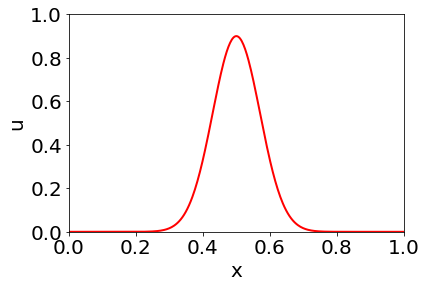

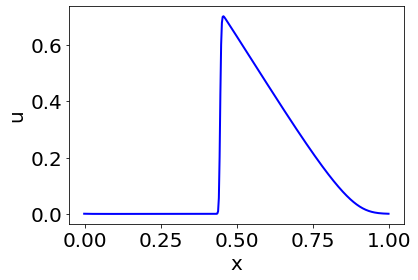

In [15]:
fig, ax = plt.subplots()
line, = ax.plot(x,UU[0], 'r-',linewidth=2)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.xlabel('x'); plt.ylabel('u'); 

def update(i):
    new_data = UU[i,:]
    line.set_ydata(new_data)
    return line,

ani = animation.FuncAnimation(fig, update, frames=nt, interval=100, blit=False)
plt.show()
ani.save('trafego.mp4') 
fig2, ax = plt.subplots()
plt.plot(x,UU[100], 'b-',linewidth=2)
plt.xlabel('x'); plt.ylabel('u');
plt.show()

Começamos com uma distribuição suave de carros, mas o sistema evolui para uma distribuição com uma descontinuidade! Será real ou um erro?

Analisemos o que seria de esperar. Na região de baixa densidade atrás do pico, os carros deslocam-se a uma velocidade superior aos que estão na região de maior congestionamento mais à frente. Assim alcançam-nos, aumentando a densidade, e conduzindo a um aumento brusco da densidade na parte de trás do congestionamento. Isto leva, eventualmente, a um engarrafamento: carros antes do congestionamento viajam depressa (têm a estrada livre), até que de repente atingem uma zona altamente congestionada, pelo que têm que travar a fundo!

### Exercicíos

1. Falamos na condição de CFL para a equação de advecção (mais exactamente, para cada método de a resolver!). Para aplicar essa condição num problema não-linear, devemos substituir a velocidade $v$ (constante) do problema da advecção pela velocidade característica (neste caso $1-2u$). Para este problema, quão grande pode ser o passo no tempo para obedecer à condição CFL?

2. Simule o que se passa quando os carros atingem um sinal vermelho. Coloque o sinal vermelho em $x=1$ e faça $u=1$ no intervalo $0.8<x<1$ (perto do semáforo, onde os carros estão parados, "encostados" ao carro à sua frente). No resto do domínio faça $u=0.2$, o que corresponde a tráfego ligeiro. Para as condições fronteira (que devem conservar "massa") use uma célula "fantasma" com $u=1$ na fronteira da direita e outra com $u=0.2$ na fronteira da esquerda. Verifique se os resultados que obtém fazem sentido, de acordo com a sua intuição do que deve acontecer.


## Velocidade de uma onda de choque: condições de Rankine-Hugoniot

No segundo exercício acima, deve ter observado uma onda de choque (ié, uma descontinuidade) que ser move para a *esquerda* à medida que mais e mais carros se acumulam a seguir ao semáforo vermelho. Com que rapidez se desloca esta descontinuidade?

Podemos calcular esta velocidade traçando uma linha imaginária na posição do choque. Seja $u_l$ a densidade de carros imediatamente à esquerda desta linha, e $u_r$ a densidade de carros imediatamente à sua direita. Imagine que a linha está parada. Então a taxa a que carros chegam à linha vindos da esquerda é dada pelo fluxo $f(u_l)$, e de um modo análogo a taxa de carros que se afasta para a direita é dada pelo fluxo $f(u_r)$. Se a linha realmente estivesse estacionária teríamos que ter  $f(u_l)-f(u_r)=0$, caso contrário haveria acumulação de carros na posição da linha.

<img src="../imagens/diagrama-choque-trafego-a.png" alt="choque" width="250"/>

Mas o choque não está estacionário, pelo que a linha se desloca. Seja $s$ a velocidade de deslocamento do choque. À medida que a linha se desloca para a esquerda, alguns carros que estavam à esquerda da linha passam a estar à sua direita. A taxa de carros retirados do lado esquerdo é $s u_l$, enquanto que a taxa de carros adicionados ao lado direito é $s u_r$. Mais uma vez, para que não haja acumulação de carros na zona do choque, os dois efeitos vistos devem-se equilibrar:

$$f(u_l) - f(u_r) = s(u_l - u_r).$$

Esta condição é conhecida como **condição de Rankine-Hugoniot**, e é obedecida por qualquer onda de choque que seja solução de uma equação hiperbólica!

<img src="../imagens/diagrama-choque-trafego-b.png" alt="choque" width="250"/>

### Exercícios

3. Use a condição de Rankine-Hugoniot para determinar a velocidade de propagação da onda de choque no problema do semáforo no vermelho visto atrás. Verifique se é a velocidade que observa. Tente repetir o problema para outros valores de $u_r$ and $u_l$ e verifique se os valores numéricos concordam com os obtidos por esta condição.

4. Estude de seguida o que acontece quando o semáforo muda para verde! Faça $u=1$ para $0<x<1/2$ e $u=0$ para $1/2<x<1$.  O que observa? Concorda com a sua experiência da vida real?

## Ondas de rarefecção

Porque é que não observamos uma onda de choque no último exercício? A função começa por ser descontínua, mas após o instante inicial torna-se contínua!

Fisicamente, a razão é evidente: após o semáforo mudar para verde, os carros na frente da fila aceleram e afastam-se; de seguida os que estvam atrás destes aceleram por sua vez e afastam-se dos imediatamente atrás, e assim sucessivamente. Temos assim uma espécie de onda de expansão, a que nos referimos como *rarefacção de carros* (por analogia com a dinâmica de fluídos!).

Como podemos saber se uma dada descontinuidade  levará a um choque ou a uma rarefacção?
- Choque formam-se em regiões onde as curvas características se sobrepõem:

<img src="../imagens/condicao-entropia-choque.png" alt="choque" width="210"/>

- Rarefacções formam-se em regiões onde as curvas características se afastam (como um leque):

<img src="../imagens/condicao-entropia-rarefac.png" alt="rarefacção" width="210"/>

De outro modo, se o valor da densidade à esquerda do choque é $u_l$ e o valor à direita é 
$u_r$, temos choque se $f'(u_l)>f'(u_r)$ (velocidade característica à esquerda maior que à direita), rarefacção se acontecer $f'(u_l)< f'(u_r)$. Na verdade a velocidade do choque deve estar entre estas duas velocidades características:

$$f'(u_l) > s > f'(u_r).$$

Dizemos que as características *colidem* com choque. Esta condição é conhecida como *condição de entropia*, porque na dinâmica de fluídos o choque deve obedecer à 2ª lei da Termodinâmica.



## O problema de Riemann

Os problemas que vimos no semáforo vermelho ou verde são exemplos do que se designa por um problema de Riemann. Este consiste numa lei de conservação hiperbólica, juntamente com um perfil inicial constante por partes, com um só ponto de descontinuidade:

$$u(x,0) = \begin{cases} u_l & x < x_0 \\ u_r & x > x_0 \end{cases}$$

O método de _upwind_ para o problema de advecção é baseado em resolver o problema de Riemann exactamente para determinar o fluxo (sendo que para essa equação o problema é de fácil resolução). Por seu lado o método do fluxo de Lax-Friedrichs é baseado numa aproximação ao problema de Riemann.

Para sistemas descritos por PDEs hiperbólicas, a solução de um problema de Riemann torna-se bastante complicada, pelo que se torna necessário desenvolver métodos computacionais baseados na resolução aproximada de problemas de Riemann.

### Referências
_Traffic flow: the Lighthill-Whithman-Richards model_, http://www.clawpack.org/riemann_book/html/Traffic_flow.html